# Calibrating the concept learning layer of concept bottleneck models

This is based heavily on [Koh et al 2020](https://arxiv.org/pdf/2007.04612) and I'm only implementing independent and sequential models because it's 6am and I wanna sleep.

Actually, sequential only, because independent doesn't benefit from calibration expect through accuracy (it takes binary concept membership inputs because that's what it's trained on).

In [19]:
import pandas as pd
import numpy as np
import torch
import os
from IPython.display import display
from scipy.special import logit, expit
import torch.nn as nn
import pickle

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from models import get_global_threshold, get_individual_thresholds
from models import get_global_similarity_log_reg, get_similarity_log_reg
from models import get_embeddings_log_reg
from models import get_global_sim_X_y, get_concept_sim_X_y

from calibration_framework import apply_platt_scaling, apply_isotonic_regression, apply_temperature_scaling
from calibration_framework import apply_histogram_binning, apply_beta_calibration

from utils import compare_all_models_calibration_metric, compare_all_models_calibration_avg, compare_all_models_calibration_concept

In [2]:
dataset_name = 'CUB'

## 1. Get pre-processed data

I don't need concept activation vectors or cosine similarities for actually doing the thing, but it can be interesting to compare.

In [3]:
metadata_df = pd.read_csv(f'../Data/{dataset_name}/metadata.csv')
embeddings = torch.load(f'Embeddings/{dataset_name}/embeddings.pt')
cosine_similarity_df = pd.read_csv(f'Cosine_Similarities/{dataset_name}/cosine_similarities.csv')

/tmp/ipykernel_276480/2056268533.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load(f'Embeddings/{dataset_name}/embeddings.pt')


In [4]:
if dataset_name == 'CLEVR':
    metadata_df = metadata_df.drop(['size::large','material::rubber'], axis=1)
    cosine_similarity_df = cosine_similarity_df.drop(['size::large','material::rubber'], axis=1)

In [5]:
concepts = list(cosine_similarity_df.columns)
classes = metadata_df['class'].unique().sort()

train_mask = metadata_df['split'] == 'train'
train_embeddings = embeddings[train_mask]
train_metadata_df = metadata_df[train_mask].reset_index(drop=True)
train_cosine_similarity_df = cosine_similarity_df[train_mask].reset_index(drop=True)
train_concepts = torch.from_numpy(train_metadata_df[concepts].to_numpy()) # each row is a k-dimensional y-value
train_labels = train_metadata_df["class"]

cal_mask = metadata_df['split'] == 'calibration'
cal_embeddings = embeddings[cal_mask]
cal_metadata_df = metadata_df[cal_mask].reset_index(drop=True)
cal_cosine_similarity_df = cosine_similarity_df[cal_mask].reset_index(drop=True)
cal_concepts = torch.from_numpy(cal_metadata_df[concepts].to_numpy())
cal_labels = cal_metadata_df["class"]

test_mask = metadata_df['split'] == 'test'
test_embeddings = embeddings[test_mask]
test_metadata_df = metadata_df[test_mask].reset_index(drop=True)
test_cosine_similarity_df = cosine_similarity_df[test_mask].reset_index(drop=True)
test_concepts = torch.from_numpy(test_metadata_df[concepts].to_numpy())
test_labels = test_metadata_df["class"]

## 2. Concept Model Utils
### a) Base Models

In [48]:
def concept_accuracies(all_y_pred, all_y_true, verbose = True):
    if verbose:
        # individual concept accuracies
        for i, concept in enumerate(concepts):
            y_true = all_y_true[:, i]
            y_pred = all_y_pred[:, i]
            accuracy = accuracy_score(y_true, y_pred)
            print(f"{i}. {concept} Test Accuracy: {accuracy * 100:.2f}%")

    # overall accuracy
    accuracy = accuracy_score(all_y_true.flatten(), all_y_pred.flatten())

    if verbose:
        print(f"Test Accuracy: {accuracy * 100:.2f}%")
    
    return accuracy

In [49]:
def target_accuracy(y_pred, y_true, verbose = True):
    accuracy = accuracy_score(y_true, y_pred)

    if verbose:
        print(f"Test Accuracy: {accuracy * 100:.2f}%")
    
    return accuracy

In [7]:
# parent class
class ConceptModel(nn.Module):
    """
    Construct a ConceptModel instance (the X-to-concept layer of a concept bottleneck model)
    === Parameters ===
    concepts : array-like of string-type elements
        List of concept names
    model_constructor : str -> nn.Module, optional, default: MLP constructor
        Function mapping a concept name to a model instance, to be used to predict the presence of that concept on data samples
    seed : int, optional, default: None (random seeds for each concept model)
        Random seed to be used in model construction. If None, no seed is provided and the classifier uses a random seed
    info : Dict
        General metadata/info. Good to include name, description, etc.
    """
    def __init__(self, concepts, seed = None, info = None):
        super(ConceptModel, self).__init__()
        self.concepts = concepts
        self.seed = seed
        self.info = info
    
    """
    Fit all concept models to training dataset
    === Parameters ===
    X : ndarray-like (n, d) where n is the number of samples and d is the dimension of elements in the input space)
        Array of input features of whatever type is acceptable to the individual concept models (probably float arrays)
    y : ndarray-like (n, k) where n is the number of samples and k is the number of concepts in the concept space)
        Array of 1-0 concept labels for X
    verbose : bool, optional, default: False
        Whether to print progress during training
    """
    def fit(self, X, y, verbose = False):
        raise NotImplementedError()
    
    """
    Predict concept probabilities on a dataset
    === Parameters ===
    X : ndarray-like (n, d) where n is the number of samples and d is the dimension of elements in the input space)
        Array of input features of whatever type is acceptable to the individual concept models (probably float arrays)
    === Output ===
    y : ndarray-like (n, k) where n is the number of samples and k is the number of concepts in the concept space)
        Array of concept probabilities in [0, 1] for X
    """
    def predict_proba(self, X):
        raise NotImplementedError()

    """
    Compute non-probabilistic concept scores on a dataset
    === Parameters ===
    X : ndarray-like (n, d) where n is the number of samples and d is the dimension of elements in the input space)
        Array of input features of whatever type is acceptable to the individual concept models (probably float arrays)
    === Output ===
    z : ndarray-like (n, k) where n is the number of samples and k is the number of concepts in the concept space)
        Array of non-probabilistic concept scores on the real line for X
    """
    def decision_function(self, X, eps = 0.000001):
        return logit(np.clip(self.predict_proba(X), eps, 1 - eps))

    """
    Predict concept labels on a dataset, given similarity scores
    === Parameters ===
    X : ndarray-like (n, d) where n is the number of samples and d is the dimension of elements in the input space)
        Array of input features of whatever type is acceptable to the individual concept models (probably float arrays)
    === Output ===
    y : ndarray-like (n, k) where n is the number of samples and k is the number of concepts in the concept space)
        Matrix of 0-1 concept indicators for X
    """
    def predict(self, X):
        return self.predict_proba(X) > 0.5

    """
    probably calibrate something
    """

In [8]:
# because I don't have direct acccess to the concept activation vectors in this script, this API is a little wonky -- don't assume anything.
# used for M1
class CosineSimilarityModel(ConceptModel):
    def __init__(self, concepts, seed = None, info = None):
        # super(CosineSimilarityModel, self).__init__()
        # self.concepts = concepts
        # self.info = info
        super(CosineSimilarityModel, self).__init__(concepts, seed, info)
        
        self.concept_models = {}
        for concept in self.concepts:
            self.concept_models[concept] = LogisticRegression(random_state=seed, max_iter=1000)

    """
    Fit all concept models to training dataset (given X = train_cosine_similarity_df and y = train_concepts)
    === Parameters ===
    X : dataframe of shape (n, k) where n is the number of samples and k is the number of concepts in the concept space
        Matrix of similarity scores
    y : ndarray-like (n, k) where n is the number of samples and k is the number of concepts in the concept space)
        Matrix of 1-0 concept labels for X
    verbose : bool, optional, default: False
        Whether to print progress during training
    """
    def fit(self, X, y, verbose = False):
        for i, concept in enumerate(self.concepts):
            X_concept = X[concept].to_numpy().reshape(-1, 1)
            y_concept = y[:, i]
            if verbose:
                print("{:03d}. Training {} detector with {} positive examples (of {})".format(i, concept, y_concept.sum(), len(y_concept)))
            self.concept_models[concept].fit(X_concept, y_concept)

    """
    Predict concept probabilities on a dataset, given similarity scores
    === Parameters ===
    X : dataframe of shape (n, k) where n is the number of samples and k is the number of concepts in the concept space
        Matrix of similarity scores
    === Output ===
    y : ndarray-like (n, k) where n is the number of samples and k is the number of concepts in the concept space)
        Matrix of concept probabilities in [0, 1] for X
    """
    def predict_proba(self, X):
        y = np.empty(shape=(len(X), len(self.concepts)))
        for i, concept in enumerate(self.concepts):
            y[:, i] = self.concept_models[concept].predict_proba(X[concept].to_numpy().reshape(-1, 1))[:, 1] # only need positive label probabilities
        return y

In [9]:
"""
used for M2 (slow)
"""
class MLPConceptModel(ConceptModel):
    def __init__(self, concepts, seed = None, info = None):
        super(MLPConceptModel, self).__init__(concepts, seed, info)
        
        self.model_constructor = lambda concept : MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=200) if self.seed is None else MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=200, random_state = self.seed)
        
        self.concept_models = {}
        for concept in self.concepts:
            self.concept_models[concept] = self.model_constructor(concept)
    
    def fit(self, X, y, verbose = False):
        for i, concept in enumerate(self.concepts):
            y_concept = y[:, i]
            if verbose:
                print("{:03d}. Training {} detector with {} positive examples (of {})".format(i, concept, y_concept.sum(), len(y_concept)))
            self.concept_models[concept].fit(X, y_concept)

    def predict_proba(self, X):
        y = np.empty(shape=(len(X), len(self.concepts)))
        for i, concept in enumerate(self.concepts):
            y[:, i] = self.concept_models[concept].predict_proba(X)[:, 1] # only need positive label probabilities
        return y

In [10]:
"""
used for M3 (a little less slow)
"""
class RandomForestConceptModel(ConceptModel):
    def __init__(self, concepts, n_estimators = 100, max_depth = 3, seed = None, info = None):
        super(RandomForestConceptModel, self).__init__(concepts, seed, info)
        self.max_depth = max_depth
        self.n_estimators = n_estimators

        if seed is None:
            self.model = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth)
        else:
            self.model = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, random_state = seed)
    
    def fit(self, X, y, verbose = False):
        self.model.fit(X, y)

    def predict_proba(self, X):
        return np.array(self.model.predict_proba(X))[:, :, 1].T

    # def predict(self, X):
    #     # same as return self.predict_proba > 0.5
    #     return self.model.predict(X)

### b) Calibrators

In [57]:
class CalibratedConceptModel(ConceptModel):
    def __init__(self, base_model, method, individual, info = {}):
        super(CalibratedConceptModel, self).__init__(base_model.concepts)
        self.base_model = base_model
        self.method = method # string
        self.individual = individual
        self.info = info

    """
    self.logits : True if the calibrator takes in logits, False if it takes in probabilities
    """
    def _make_calibrator(self):
        if self.method == 'Histogram':
            self.logits = False
            from netcal.binning import HistogramBinning as HB
            nbins = self.info['nbins'] if 'nbins' in self.info.keys() else 10
            return HB(nbins, detection = False)
        elif self.method == 'Isotonic':
            self.logits = False
            from netcal.binning import IsotonicRegression as IR
            return IR(detection = False)
        elif self.method == 'Platt':
            self.logits = False # I guess it does this itself?
            from netcal.scaling import LogisticCalibration as LC
            return LC(temperature_only = False, method = "mle", detection = False)
        elif self.method == 'Temperature':
            self.logits = False # I guess it does this itself?
            from netcal.scaling import LogisticCalibration as LC
            return LC(temperature_only = True, method = "mle", detection = False)
        elif self.method == 'Beta':
            self.logits = False
            from netcal.scaling import BetaCalibration as BC
            return BC(method = "mle", detection = False)
            
    def _make_calibrators(self):
        if self.individual:
            self.calibrators = {}
            for concept in self.concepts:
                self.calibrators[concept] = self._make_calibrator()
        else:
            self.calibrator = self._make_calibrator()

    def calibrate(self, X, y):
        self._make_calibrators()
        
        if self.logits:
            z = self.base_model.decision_function(X) # (n_cal, k,)
        else:
            z = self.base_model.predict_proba(X)
        
        if self.individual:
            for i, concept in enumerate(self.concepts):
                self.calibrators[concept].fit(z[:, i], y[:, i])
        else:
            self.calibrator.fit(z.flatten(), y.flatten())
    
    def predict_proba(self, X):
        z = self.base_model.predict_proba(X)
        if self.logits:
            z = self.base_model.decision_function(X)
        else:
            z = self.base_model.predict_proba(X)

        if self.individual:
            for i, concept in enumerate(self.concepts):
                z[:, i] = self.calibrators[concept].transform(z[:, i])
        else:
            #z = self.calibrator.transform(z) # shape issue
            for i, concept in enumerate(self.concepts):
                z[:, i] = self.calibrator.transform(z[:, i])
        
        return z

## 3. Train concept models
Cosine similarity based models that take in foundation model-derived embeddings.

$M_1$ : Logistic regression from concept similarity score to concept presence probability, for each concept (2 parameters trained on labelled concepts)

$M_2$ : MLP from embedding to concept presence probability, for each concept (neural net trained on labelled concepts)

$M_3$ : Random forest classifier from embedding to concept presence probabilities, handles all concepts at once

Maybe eventually, base models from the previous paper

$M_2$ is horrifically slow so we're skipping it for now.

### a) Base sequential models

In [58]:
if False:
    M1 = CosineSimilarityModel(concepts=concepts, seed = 42)
    M1.fit(train_cosine_similarity_df, train_concepts, verbose = False)
    
    # save
    with open('Models/CBM-M1.pkl','wb') as f:
        pickle.dump(M1, f)
else:
    # load
    with open('Models/CBM-M1.pkl', 'rb') as f:
        M1 = pickle.load(f)

In [59]:
M1_test_concepts_pred = M1.predict(test_cosine_similarity_df)
M1_acc = accuracies(M1_test_concepts_pred, test_concepts.numpy(), verbose = True)

0. has_back_color::black Test Accuracy: 78.05%
1. has_back_color::blue Test Accuracy: 96.55%
2. has_back_color::brown Test Accuracy: 79.93%
3. has_back_color::buff Test Accuracy: 85.03%
4. has_back_color::green Test Accuracy: 98.47%
5. has_back_color::grey Test Accuracy: 76.66%
6. has_back_color::iridescent Test Accuracy: 98.34%
7. has_back_color::olive Test Accuracy: 96.64%
8. has_back_color::orange Test Accuracy: 98.73%
9. has_back_color::pink Test Accuracy: 99.61%
10. has_back_color::purple Test Accuracy: 99.65%
11. has_back_color::red Test Accuracy: 98.65%
12. has_back_color::rufous Test Accuracy: 99.21%
13. has_back_color::white Test Accuracy: 84.60%
14. has_back_color::yellow Test Accuracy: 93.15%
15. has_back_pattern::multi-colored Test Accuracy: 80.32%
16. has_back_pattern::solid Test Accuracy: 64.79%
17. has_back_pattern::spotted Test Accuracy: 93.11%
18. has_back_pattern::striped Test Accuracy: 85.12%
19. has_belly_color::black Test Accuracy: 88.87%
20. has_belly_color::blue 

In [60]:
if False:
    M2 = MLPConceptModel(concepts, seed = 42)
    M2.fit(train_embeddings, train_concepts, verbose = True)

In [61]:
if False:
    M2_test_concepts_pred = M2.predict(test_embeddings)
    M2_acc = accuracies(M2_test_concepts_pred, test_concepts.numpy(), verbose = True)

In [62]:
if False:
    M3 = RandomForestConceptModel(concepts, seed = 42)
    M3.fit(train_embeddings, train_concepts, verbose = True)
    
    # save
    with open('Models/CBM-M3.pkl','wb') as f:
        pickle.dump(M3, f)
else:
    # load
    with open('Models/CBM-M3.pkl', 'rb') as f:
        M3 = pickle.load(f)

In [63]:
M3_test_concepts_pred = M3.model.predict(test_embeddings)
M3_acc = accuracies(M3_test_concepts_pred, test_concepts.numpy(), verbose = True)

0. has_back_color::black Test Accuracy: 71.90%
1. has_back_color::blue Test Accuracy: 95.86%
2. has_back_color::brown Test Accuracy: 80.89%
3. has_back_color::buff Test Accuracy: 86.04%
4. has_back_color::green Test Accuracy: 98.47%
5. has_back_color::grey Test Accuracy: 74.52%
6. has_back_color::iridescent Test Accuracy: 98.34%
7. has_back_color::olive Test Accuracy: 96.64%
8. has_back_color::orange Test Accuracy: 98.73%
9. has_back_color::pink Test Accuracy: 99.61%
10. has_back_color::purple Test Accuracy: 99.65%
11. has_back_color::red Test Accuracy: 98.69%
12. has_back_color::rufous Test Accuracy: 99.21%
13. has_back_color::white Test Accuracy: 84.60%
14. has_back_color::yellow Test Accuracy: 93.02%
15. has_back_pattern::multi-colored Test Accuracy: 80.32%
16. has_back_pattern::solid Test Accuracy: 62.65%
17. has_back_pattern::spotted Test Accuracy: 93.11%
18. has_back_pattern::striped Test Accuracy: 85.56%
19. has_belly_color::black Test Accuracy: 85.30%
20. has_belly_color::blue 

In [64]:
base_concept_models = {'(M1) Cosine Similarity LogReg': M1,
          #'(M2) Embeddings MLP': M2,
          '(M3) Embeddings Random Forest': M3
         }

### b) Calibrate models

In [65]:
M1_concepts_cal = {}

for method in ['Histogram', 'Isotonic', 'Platt', 'Temperature', 'Beta']:
    for i, version in enumerate(['global', 'individual']):
        name = '{} {}'.format(method, version)
        print(name)
        M1_concepts_cal[name] = CalibratedConceptModel(M1, method = method, individual = i)
        M1_concepts_cal[name].calibrate(cal_cosine_similarity_df, cal_concepts.numpy())

In [66]:
M3_concepts_cal = {}

for method in ['Histogram', 'Isotonic', 'Platt', 'Temperature', 'Beta']:
    for i, version in enumerate(['global', 'individual']):
        name = '{} {}'.format(method, version)
        print(name)
        M3_concepts_cal[name] = CalibratedConceptModel(M3, method = method, individual = i)
        M3_concepts_cal[name].calibrate(cal_embeddings, cal_concepts.numpy())

Histogram global
Histogram individual
Isotonic global
Isotonic individual
Platt global
Platt individual
Temperature global
Temperature individual
Beta global
Beta individual


In [67]:
calibrated_models = {'(M1) Cosine Similarity LogReg': M1_concepts_cal,
                     #'(M2) Embeddings MLP': M2_models_cal,
                     '(M3) Embeddings Random Forest': M3_concepts_cal
                    }

## 5. Train sequential target models

Per the paper I'm basing all of this off of, this is basically just training a logistic activation layer

### a) Base concept models

In [68]:
if False:
    M1_seq = LogisticRegression(random_state=42, max_iter=1000)
    M1_seq.fit(M1.decision_function(train_cosine_similarity_df), train_labels)
    
    # save
    with open('Models/CBM-M1-seq.pkl','wb') as f:
        pickle.dump(M1_seq, f)
else:
    # load
    with open('Models/CBM-M1-seq.pkl', 'rb') as f:
        M1_seq = pickle.load(f)

In [ ]:
if True:
    M3_seq = LogisticRegression(random_state=42, max_iter=1000)
    M3_seq.fit(M3.decision_function(train_embeddings), train_labels)
    
    # save
    with open('Models/CBM-M3-seq.pkl','wb') as f:
        pickle.dump(M3_seq, f)
else:
    # load
    with open('Models/CBM-M3-seq.pkl', 'rb') as f:
        M3_seq = pickle.load(f)

### b) Calibrated concept models

In [ ]:
M1_seq_cal = {}

refit = {'Histogram global' : False, 'Histogram individual' : True, 'Isotonic global' : True, 'Isotonic individual' : True}

for method in ['Histogram', 'Isotonic']: #, 'Platt', 'Temperature', 'Beta']:
    for i, version in enumerate(['global', 'individual']):
        name = '{} {}'.format(method, version)
        fname = 'Models/CBM-M1-seq-cal-{}-{}.pkl'.format(method, version)
        if refit[name]:
            print(name)
            M1_seq_cal[name] = LogisticRegression(random_state=42, max_iter=1000)
            ##
            # better way
            train_concepts_pred = M1_concepts_cal[name].decision_function(train_cosine_similarity_df)
            # current way
            train_concepts_pred = M1_concepts_cal[name].predict_proba(train_cosine_similarity_df)
            eps = 0.000001
            train_concepts_pred = logit(np.clip(train_concepts_pred, eps, 1 - eps))
            ##
            M1_seq_cal[name].fit(train_concepts_pred, train_labels)
            
            # save
            with open(fname, 'wb') as f:
                pickle.dump(M1_seq_cal[name], f)
        else:
            # load
            with open(fname, 'rb') as f:
                M1_seq_cal[name] = pickle.load(f)

Histogram individual


(array([2.780000e+02, 0.000000e+00, 1.218050e+05, 1.402897e+06,
        6.064030e+05, 1.022880e+05, 8.000000e+02, 0.000000e+00,
        0.000000e+00, 1.009000e+03]),
 array([-1.38155096e+01, -1.10524076e+01, -8.28930573e+00, -5.52620382e+00,
        -2.76310191e+00, -1.43796086e-11,  2.76310191e+00,  5.52620382e+00,
         8.28930573e+00,  1.10524076e+01,  1.38155096e+01]),
 <BarContainer object of 10 artists>)

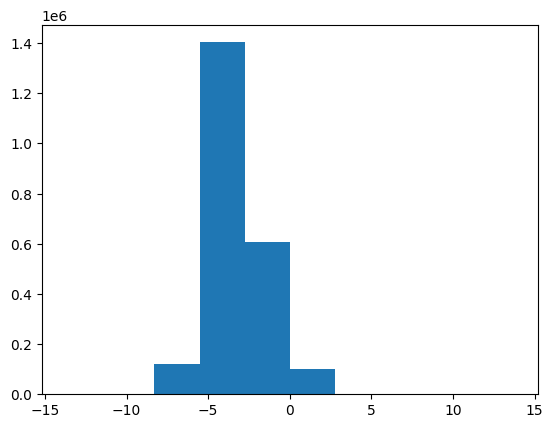

In [85]:
from matplotlib import pyplot as plt
plt.hist(train_concepts_pred.flatten())

In [ ]:
M3_seq_cal = {}

for method in ['Histogram', 'Isotonic', 'Platt', 'Temperature', 'Beta']:
    for i, version in enumerate(['global', 'individual']):
        name = '{} {}'.format(method, version)
        print(name)
        M3_seq_cal[name] = LogisticRegression(random_state=42, max_iter=1000)
        M3_seq_cal[name].fit(M3_concepts_cal[name].decision_function(train_embeddings), train_labels)

## 6. Evaluate

In [51]:
M1_test_concepts_pred = M1.decision_function(test_cosine_similarity_df)
M1_test_target_pred = M1_seq.predict(M1_test_concepts_pred)
M1_seq_acc = target_accuracy(M1_test_target_pred, test_labels.to_numpy(), verbose = True)

Test Accuracy: 83.03%


In [71]:
for method in ['Histogram']: #, 'Isotonic', 'Platt', 'Temperature', 'Beta']:
    for i, version in enumerate(['global']): #, 'individual']):
        name = '{} {}'.format(method, version)
        print(name)
        M1_cal_test_concepts_pred = M1_concepts_cal[name].decision_function(test_cosine_similarity_df)
        M1_cal_test_target_pred = M1_seq_cal[name].predict(M1_cal_test_concepts_pred)
        M1_seq_acc = target_accuracy(M1_cal_test_target_pred, test_labels.to_numpy(), verbose = True)

Histogram global
Test Accuracy: 71.82%


In [72]:
# damn